In [1]:
# Section 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import time
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Section 2: Data Loading and Preparation
def load_datasets(training_folder, testing_folder):
    """
    Load all training and testing datasets
    """
    training_sets = {}
    testing_sets = {}
    
    # Load training sets (1-5)
    for i in range(1, 6):
        filename = f"{training_folder}/set_{i}.csv"
        training_sets[f'set_{i}'] = pd.read_csv(filename)
        print(f"Loaded {filename} with shape: {training_sets[f'set_{i}'].shape}")
    
    # Load testing set (6)
    testing_sets['set_6'] = pd.read_csv(f"{testing_folder}/set_6.csv")
    print(f"Loaded testing set with shape: {testing_sets['set_6'].shape}")
    
    return training_sets, testing_sets

# Load the data
training_sets, testing_sets = load_datasets('training_set', 'testing_set')

Loaded training_set/set_1.csv with shape: (30, 44)
Loaded training_set/set_2.csv with shape: (30, 44)
Loaded training_set/set_3.csv with shape: (30, 44)
Loaded training_set/set_4.csv with shape: (30, 44)
Loaded training_set/set_5.csv with shape: (30, 44)
Loaded testing set with shape: (35, 44)


In [6]:
# Section 3: Data Preprocessing Function
def preprocess_data(df):
    """
    Preprocess the data: handle missing values, convert date, etc.
    """
    df_clean = df.copy()
    
    # Convert date to datetime and extract features
    df_clean['date'] = pd.to_datetime(df_clean['date'])
    df_clean['day_of_week'] = df_clean['date'].dt.dayofweek
    df_clean['day_of_month'] = df_clean['date'].dt.day
    df_clean['month'] = df_clean['date'].dt.month
    
    # Handle missing values - fill with forward fill then backward fill
    df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')
    
    # Drop the date column as we've extracted temporal features
    df_clean = df_clean.drop('date', axis=1)
    
    return df_clean

# Preprocess all datasets
training_sets_processed = {key: preprocess_data(df) for key, df in training_sets.items()}
testing_sets_processed = {key: preprocess_data(df) for key, df in testing_sets.items()}

In [7]:
# Section 4: Model Definitions and Setup
def create_models():
    """
    Create and return all models with their pipelines
    """
    models = {}
    
    # Polynomial Regression
    poly_reg = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ])
    models['Polynomial Regression'] = poly_reg
    
    # Random Forest
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    models['Random Forest'] = rf
    
    # SVR
    svr = Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.1))
    ])
    models['SVR'] = svr
    
    # MLP
    mlp = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            random_state=42,
            max_iter=1000
        ))
    ])
    models['MLP'] = mlp
    
    return models

# Initialize models
models = create_models()

In [8]:
# Section 5: Cross-Validation Training and Evaluation
def perform_cross_validation(training_sets, models):
    """
    Perform cross-validation where each set is used as test set once
    """
    cv_results = {model_name: [] for model_name in models.keys()}
    training_times = {model_name: [] for model_name in models.keys()}
    
    set_names = list(training_sets.keys())
    
    for i, test_set_name in enumerate(set_names):
        print(f"\n=== Cross-validation fold: Using {test_set_name} as test set ===")
        
        # Prepare training and test data
        X_test = training_sets[test_set_name].drop('deaths_new', axis=1)
        y_test = training_sets[test_set_name]['deaths_new']
        
        # Combine all other sets for training
        train_sets = [training_sets[name] for name in set_names if name != test_set_name]
        train_data = pd.concat(train_sets, ignore_index=True)
        
        X_train = train_data.drop('deaths_new', axis=1)
        y_train = train_data['deaths_new']
        
        # Train and evaluate each model
        for model_name, model in models.items():
            print(f"Training {model_name}...")
            
            # Measure training time
            start_time = time.time()
            model.fit(X_train, y_train)
            training_time = time.time() - start_time
            training_times[model_name].append(training_time)
            
            # Make predictions
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            
            cv_results[model_name].append({
                'test_set': test_set_name,
                'mae': mae,
                'mse': mse,
                'rmse': rmse,
                'r2': r2,
                'training_time': training_time,
                'actual_values': y_test.values,
                'predicted_values': y_pred
            })
            
            print(f"{model_name} - RMSE: {rmse:.2f}, R²: {r2:.3f}, Time: {training_time:.2f}s")
    
    return cv_results, training_times

# Perform cross-validation
cv_results, training_times = perform_cross_validation(training_sets_processed, models)


=== Cross-validation fold: Using set_1 as test set ===
Training Polynomial Regression...
Polynomial Regression - RMSE: 71.08, R²: 0.740, Time: 0.08s
Training Random Forest...
Random Forest - RMSE: 60.54, R²: 0.811, Time: 0.15s
Training SVR...
SVR - RMSE: 144.21, R²: -0.070, Time: 0.01s
Training MLP...
MLP - RMSE: 58.01, R²: 0.827, Time: 0.67s

=== Cross-validation fold: Using set_2 as test set ===
Training Polynomial Regression...
Polynomial Regression - RMSE: 66.17, R²: 0.684, Time: 0.01s
Training Random Forest...
Random Forest - RMSE: 23.86, R²: 0.959, Time: 0.14s
Training SVR...
SVR - RMSE: 111.10, R²: 0.110, Time: 0.00s
Training MLP...
MLP - RMSE: 29.24, R²: 0.938, Time: 0.68s

=== Cross-validation fold: Using set_3 as test set ===
Training Polynomial Regression...
Polynomial Regression - RMSE: 68.22, R²: 0.385, Time: 0.01s
Training Random Forest...
Random Forest - RMSE: 44.34, R²: 0.740, Time: 0.14s
Training SVR...
SVR - RMSE: 69.16, R²: 0.368, Time: 0.00s
Training MLP...
MLP - R

In [10]:
# Section 6: Analyze Cross-Validation Results
def analyze_cv_results(cv_results, training_times):
    """
    Analyze and display cross-validation results
    """
    metrics = ['mae', 'rmse', 'r2']
    results_summary = {}
    
    print("=== CROSS-VALIDATION RESULTS SUMMARY ===")
    print("="*50)
    
    for model_name in cv_results.keys():
        model_results = cv_results[model_name]
        
        # Calculate average metrics
        avg_metrics = {}
        for metric in metrics:
            avg_metrics[metric] = np.mean([result[metric] for result in model_results])
        
        avg_training_time = np.mean(training_times[model_name])
        
        results_summary[model_name] = {
            'avg_mae': avg_metrics['mae'],
            'avg_rmse': avg_metrics['rmse'],
            'avg_r2': avg_metrics['r2'],
            'avg_training_time': avg_training_time
        }
        
        print(f"\n{model_name}:")
        print(f"  Average MAE: {avg_metrics['mae']:.2f}")
        print(f"  Average RMSE: {avg_metrics['rmse']:.2f}")
        print(f"  Average R²: {avg_metrics['r2']:.3f}")
        print(f"  Average Training Time: {avg_training_time:.2f}s")
    
    return results_summary

# Analyze results
results_summary = analyze_cv_results(cv_results, training_times)

=== CROSS-VALIDATION RESULTS SUMMARY ===

Polynomial Regression:
  Average MAE: 49.92
  Average RMSE: 69.36
  Average R²: 0.547
  Average Training Time: 0.02s

Random Forest:
  Average MAE: 26.69
  Average RMSE: 41.07
  Average R²: 0.845
  Average Training Time: 0.15s

SVR:
  Average MAE: 72.21
  Average RMSE: 101.77
  Average R²: 0.175
  Average Training Time: 0.00s

MLP:
  Average MAE: 30.22
  Average RMSE: 46.65
  Average R²: 0.786
  Average Training Time: 0.66s


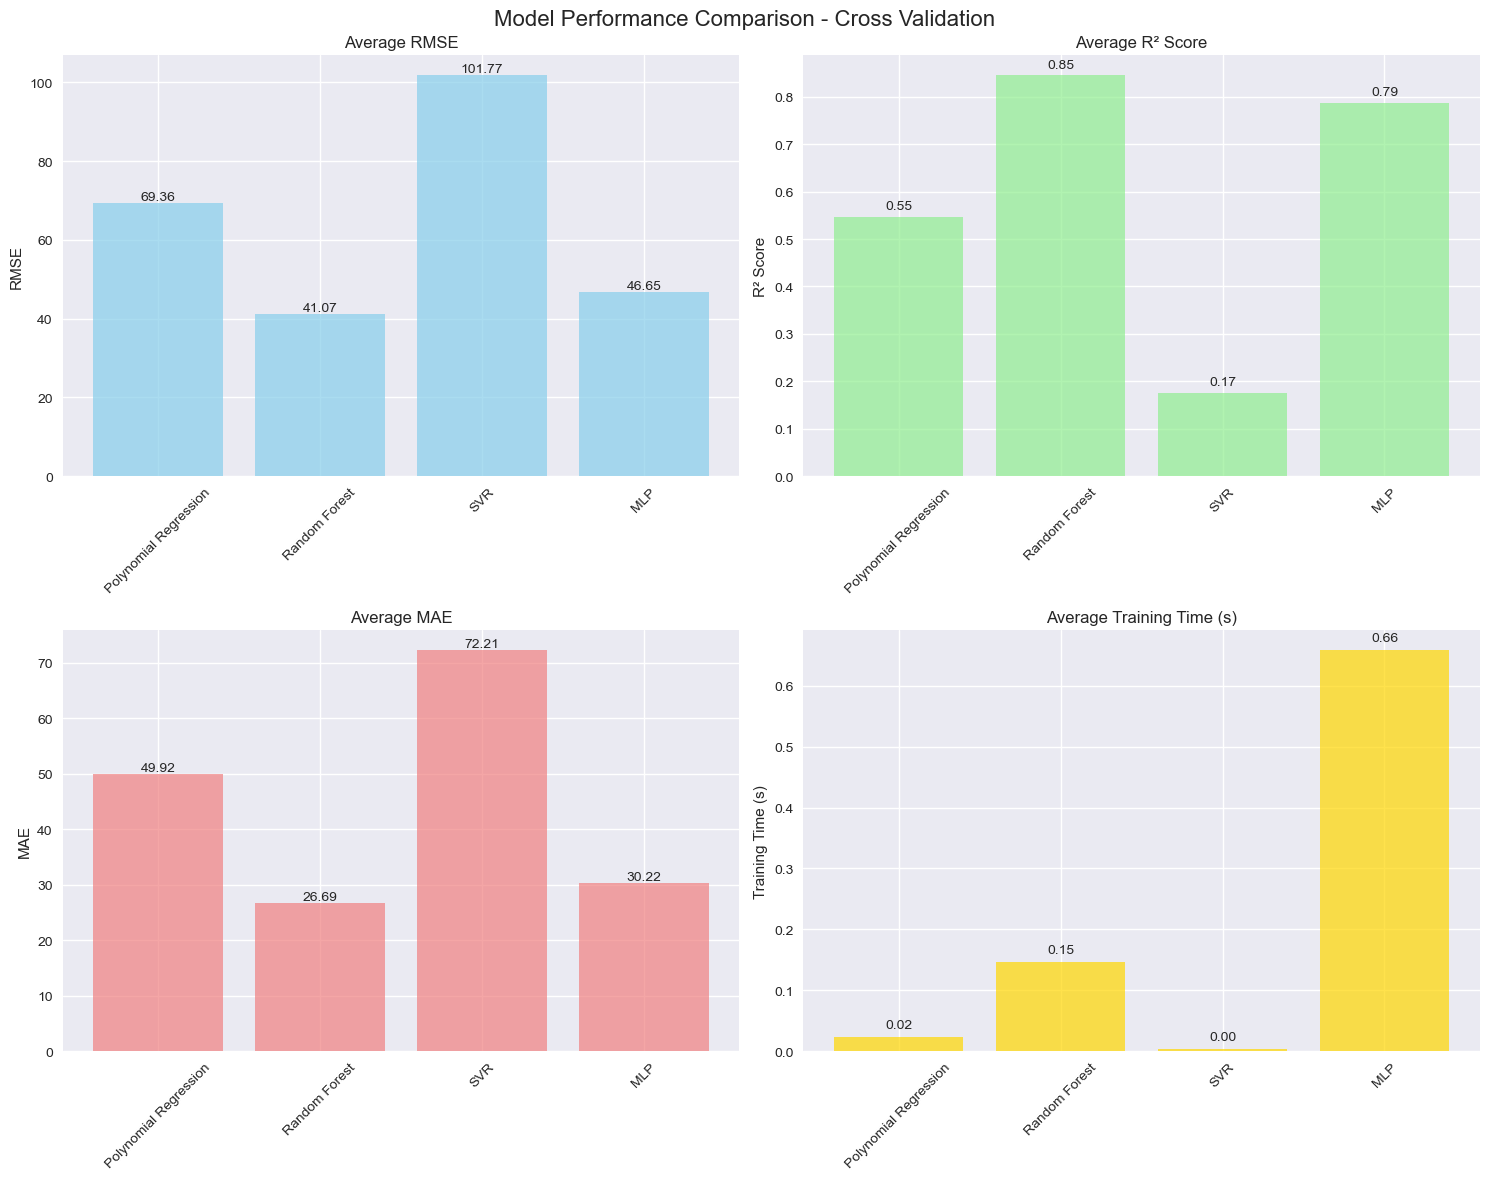

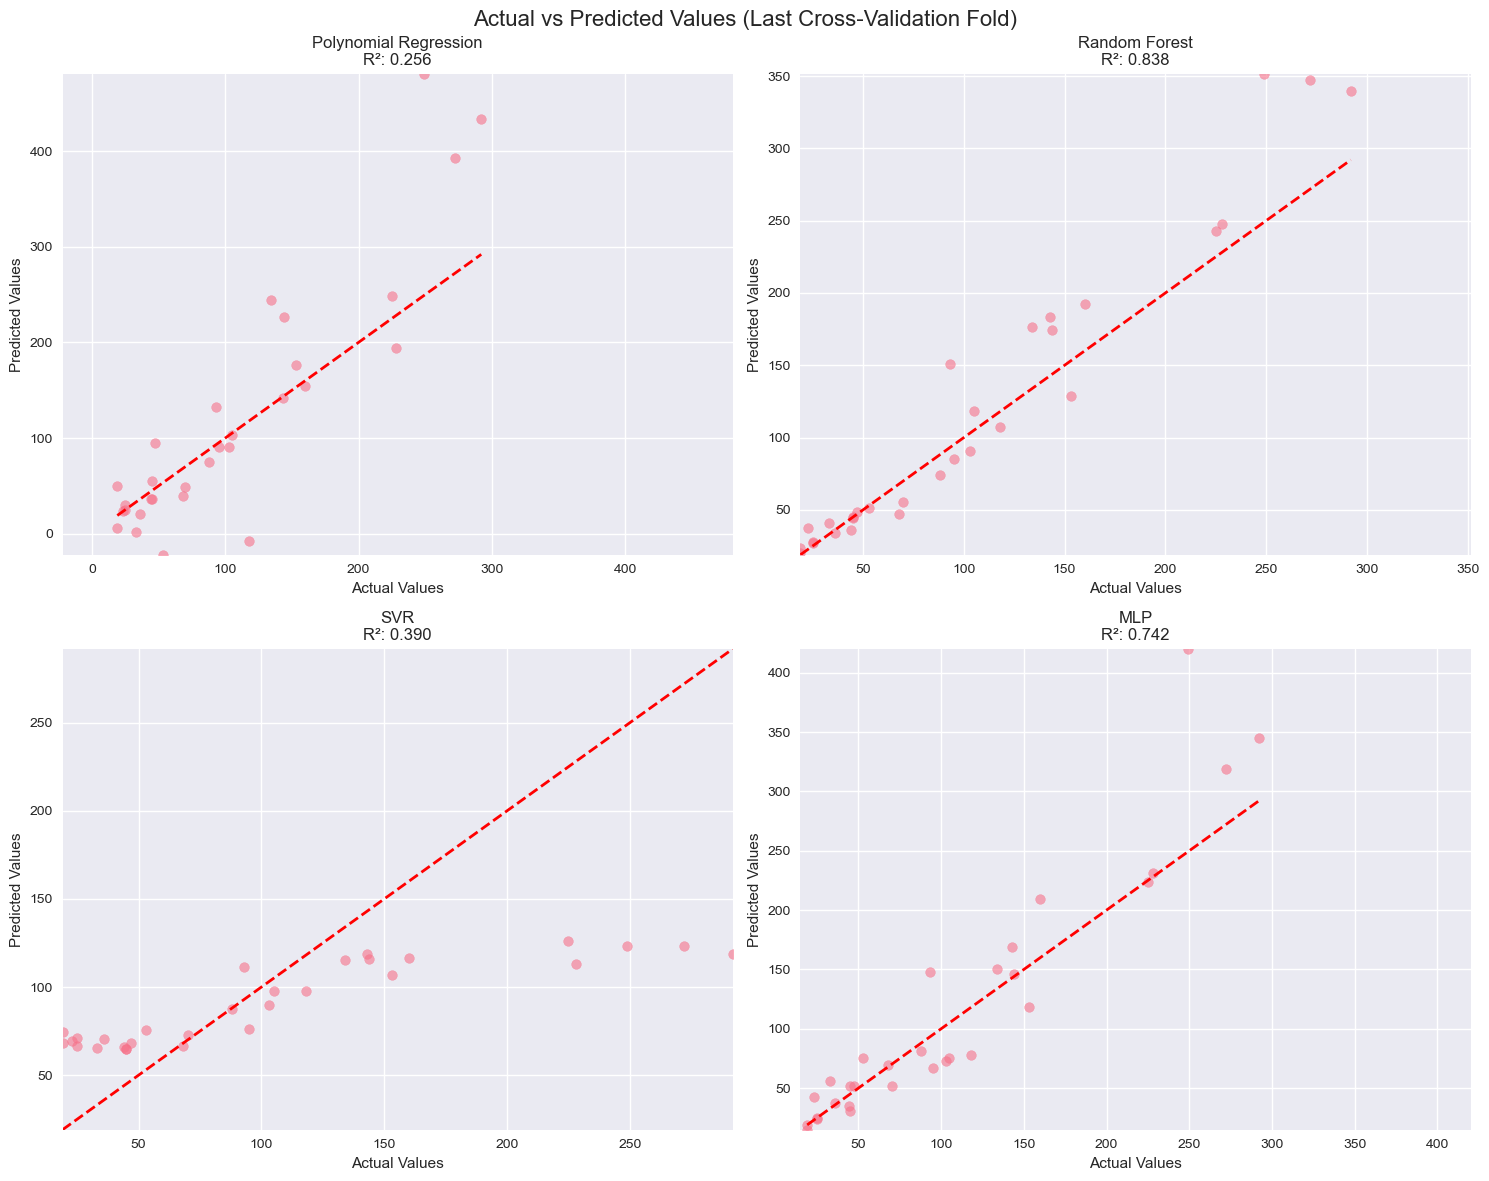

In [11]:
# Section 7: Plot Cross-Validation Results
def plot_cv_results(cv_results, results_summary):
    """
    Create visualizations for cross-validation results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Performance Comparison - Cross Validation', fontsize=16)
    
    # Prepare data for plotting
    model_names = list(results_summary.keys())
    metrics = ['avg_rmse', 'avg_r2', 'avg_mae', 'avg_training_time']
    metric_names = ['RMSE', 'R² Score', 'MAE', 'Training Time (s)']
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
    
    # Bar plots for each metric
    for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        ax = axes[i//2, i%2]
        values = [results_summary[model][metric] for model in model_names]
        
        bars = ax.bar(model_names, values, color=colors[i], alpha=0.7)
        ax.set_title(f'Average {metric_name}')
        ax.set_ylabel(metric_name)
        ax.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Actual vs Predicted plots for each model (last fold)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Actual vs Predicted Values (Last Cross-Validation Fold)', fontsize=16)
    
    for i, (model_name, ax) in enumerate(zip(model_names, axes.flatten())):
        last_result = cv_results[model_name][-1]
        actual = last_result['actual_values']
        predicted = last_result['predicted_values']
        
        ax.scatter(actual, predicted, alpha=0.6)
        ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'{model_name}\nR²: {last_result["r2"]:.3f}')
        
        # Add perfect prediction line
        max_val = max(actual.max(), predicted.max())
        min_val = min(actual.min(), predicted.min())
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
    
    plt.tight_layout()
    plt.show()

# Plot results
plot_cv_results(cv_results, results_summary)

In [12]:
# Section 8: Final Training on All Training Data and Testing on Set 6
def final_training_and_testing(training_sets, testing_sets, models):
    """
    Train on all training data and test on set 6
    """
    # Combine all training sets
    all_train_data = pd.concat([training_sets[name] for name in training_sets.keys()], 
                              ignore_index=True)
    X_train = all_train_data.drop('deaths_new', axis=1)
    y_train = all_train_data['deaths_new']
    
    # Prepare test data (set 6)
    X_test = testing_sets['set_6'].drop('deaths_new', axis=1)
    y_test = testing_sets['set_6']['deaths_new']
    
    final_results = {}
    final_training_times = {}
    
    print("=== FINAL TRAINING AND TESTING ON SET 6 ===")
    print("="*50)
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name} on all training data...")
        
        # Measure training time
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        final_training_times[model_name] = training_time
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        final_results[model_name] = {
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'r2': r2,
            'training_time': training_time,
            'actual_values': y_test.values,
            'predicted_values': y_pred
        }
        
        print(f"{model_name} Results:")
        print(f"  MAE: {mae:.2f}")
        print(f"  RMSE: {rmse:.2f}")
        print(f"  R²: {r2:.3f}")
        print(f"  Training Time: {training_time:.2f}s")
    
    return final_results, final_training_times

# Perform final training and testing
final_results, final_training_times = final_training_and_testing(
    training_sets_processed, testing_sets_processed, models
)

=== FINAL TRAINING AND TESTING ON SET 6 ===

Training Polynomial Regression on all training data...
Polynomial Regression Results:
  MAE: 42.31
  RMSE: 67.84
  R²: 0.753
  Training Time: 0.01s

Training Random Forest on all training data...
Random Forest Results:
  MAE: 21.63
  RMSE: 48.54
  R²: 0.873
  Training Time: 0.14s

Training SVR on all training data...
SVR Results:
  MAE: 80.03
  RMSE: 124.59
  R²: 0.166
  Training Time: 0.00s

Training MLP on all training data...
MLP Results:
  MAE: 25.50
  RMSE: 49.10
  R²: 0.871
  Training Time: 0.73s


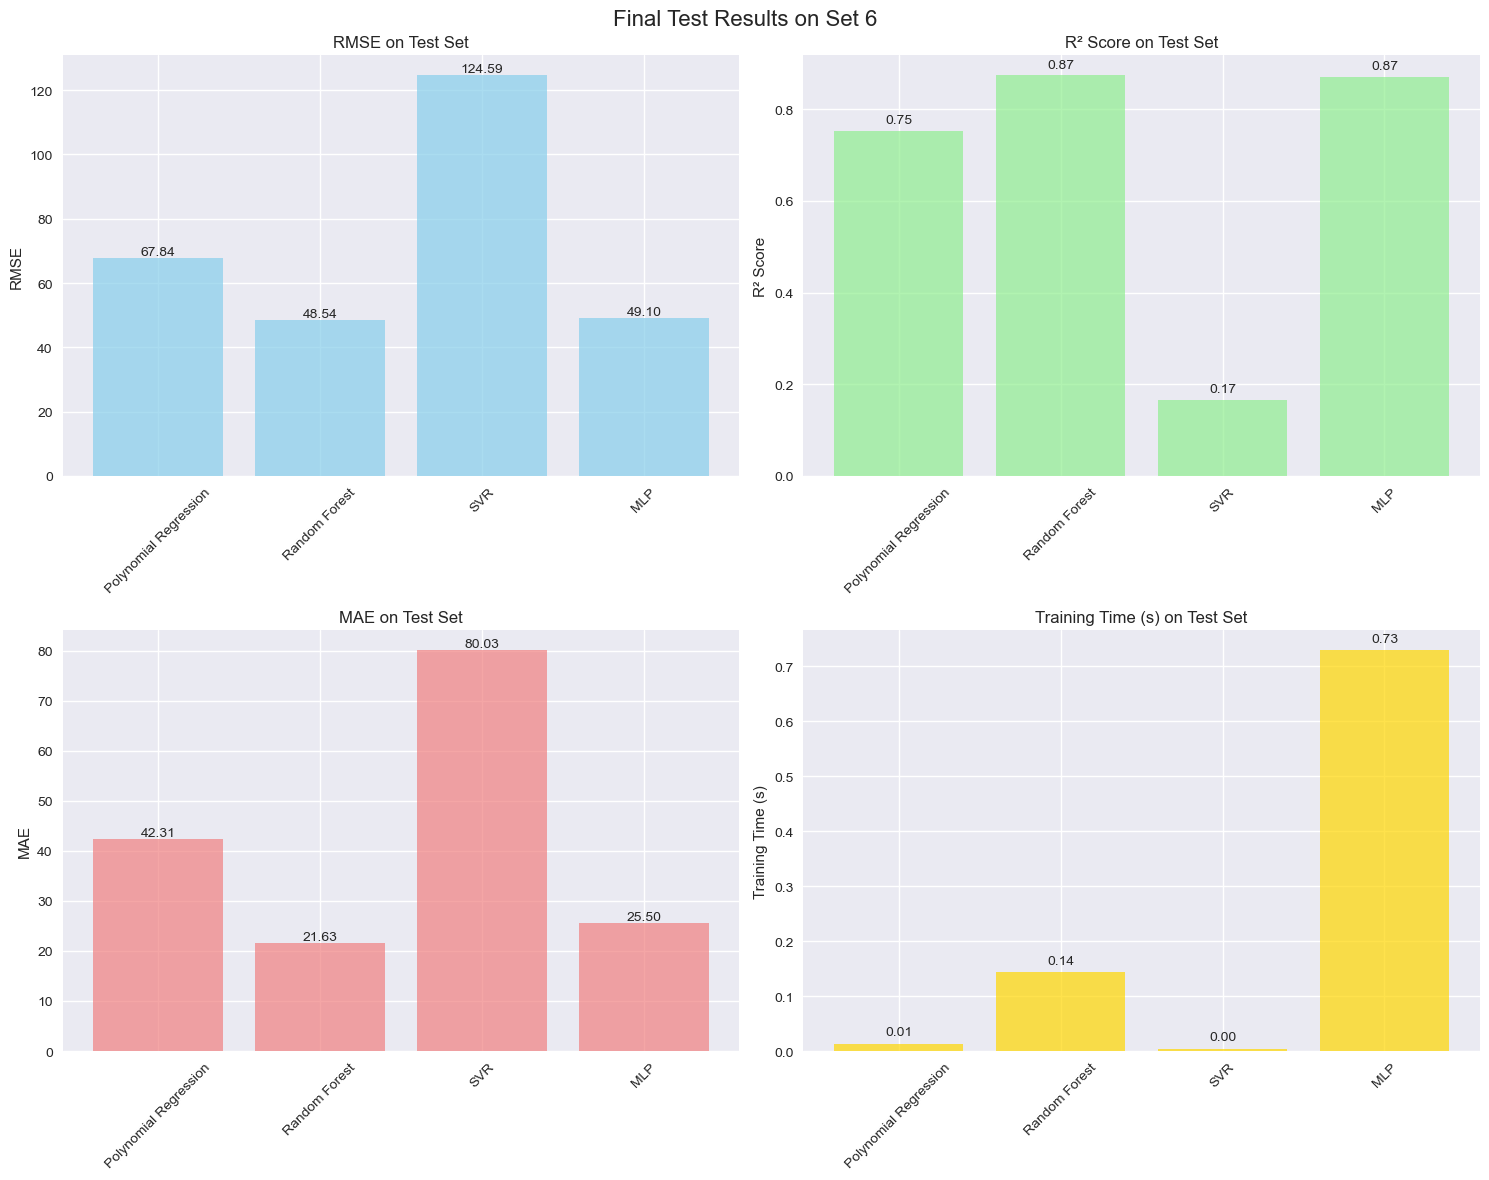

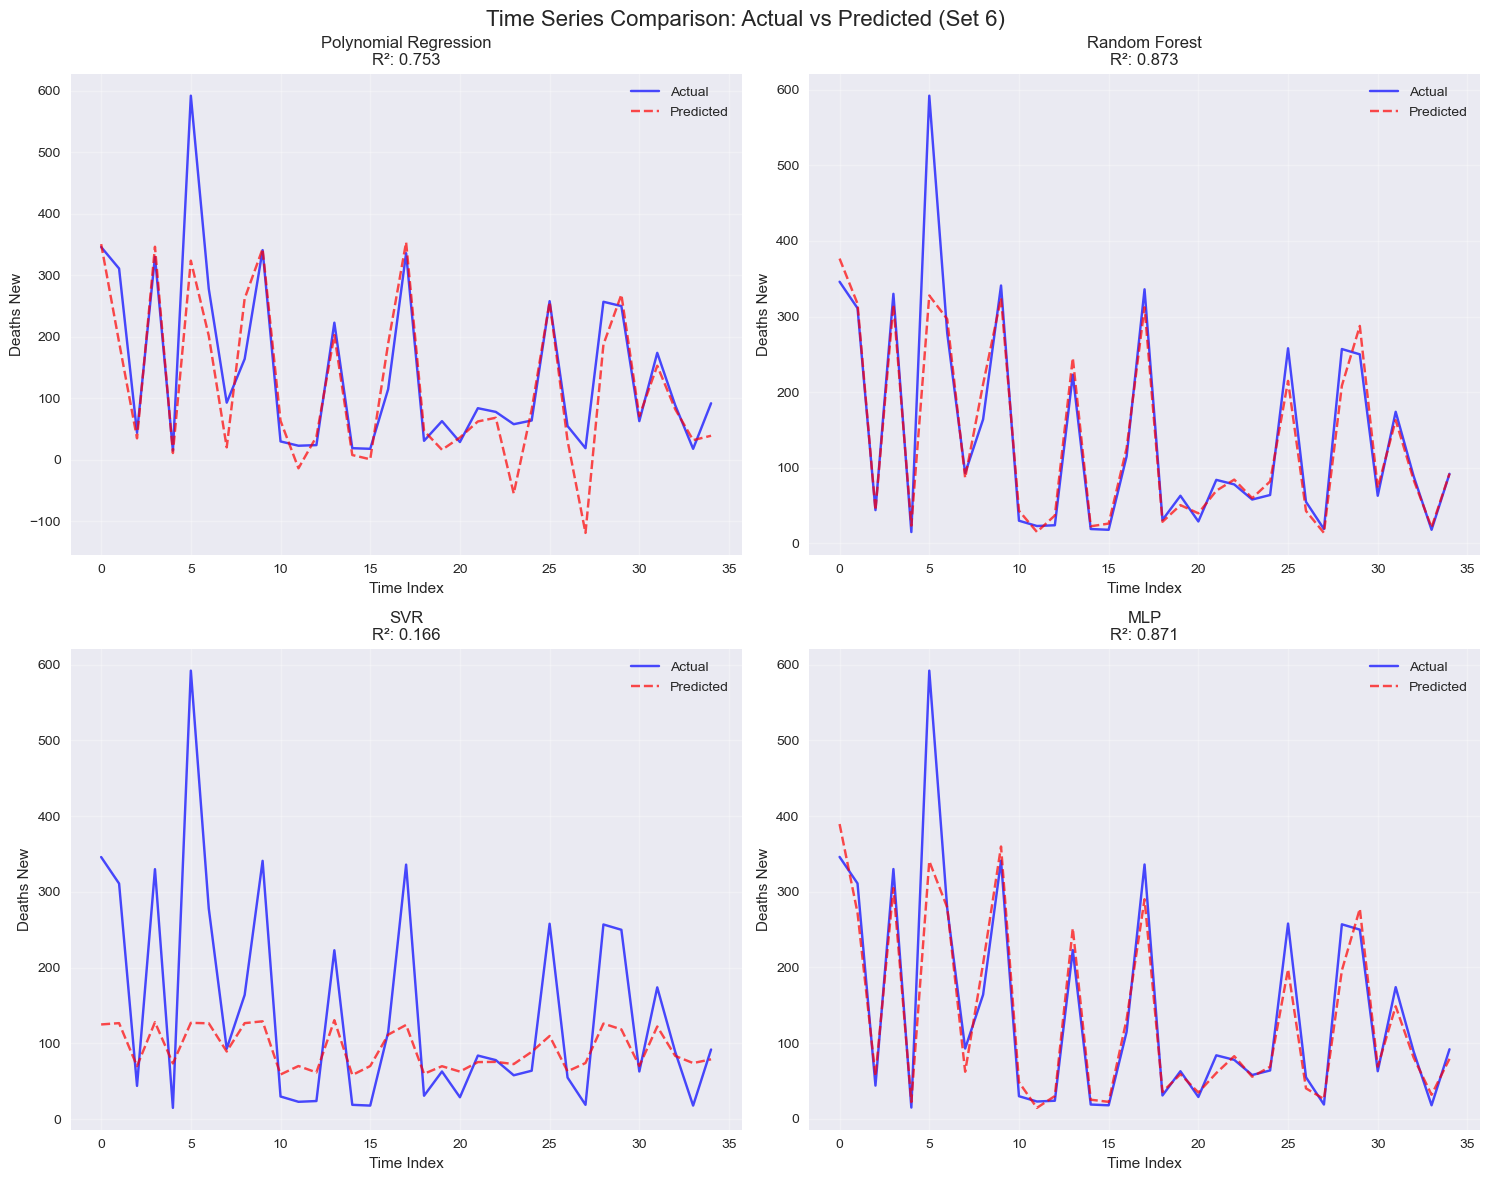

In [13]:
# Section 9: Plot Final Test Results
def plot_final_results(final_results, final_training_times):
    """
    Create visualizations for final test results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Final Test Results on Set 6', fontsize=16)
    
    # Metrics comparison
    metrics = ['rmse', 'r2', 'mae', 'training_time']
    metric_names = ['RMSE', 'R² Score', 'MAE', 'Training Time (s)']
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
    
    model_names = list(final_results.keys())
    
    for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        ax = axes[i//2, i%2]
        values = [final_results[model][metric] for model in model_names]
        
        bars = ax.bar(model_names, values, color=colors[i], alpha=0.7)
        ax.set_title(f'{metric_name} on Test Set')
        ax.set_ylabel(metric_name)
        ax.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Time series comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Time Series Comparison: Actual vs Predicted (Set 6)', fontsize=16)
    
    # Get actual values (same for all models)
    actual_values = final_results[model_names[0]]['actual_values']
    time_index = range(len(actual_values))
    
    for i, (model_name, ax) in enumerate(zip(model_names, axes.flatten())):
        predicted_values = final_results[model_name]['predicted_values']
        
        ax.plot(time_index, actual_values, 'b-', label='Actual', alpha=0.7)
        ax.plot(time_index, predicted_values, 'r--', label='Predicted', alpha=0.7)
        ax.set_xlabel('Time Index')
        ax.set_ylabel('Deaths New')
        ax.set_title(f'{model_name}\nR²: {final_results[model_name]["r2"]:.3f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot final results
plot_final_results(final_results, final_training_times)

In [15]:
# Section 10: Comprehensive Analysis and Comparison
def comprehensive_analysis(results_summary, final_results):
    """
    Provide comprehensive analysis and comparison of all models
    """
    print("=== COMPREHENSIVE ANALYSIS ===")
    print("="*40)
    
    # Create comparison dataframe
    comparison_data = []
    for model_name in results_summary.keys():
        comparison_data.append({
            'Model': model_name,
            'CV_RMSE': results_summary[model_name]['avg_rmse'],
            'CV_R2': results_summary[model_name]['avg_r2'],
            'Test_RMSE': final_results[model_name]['rmse'],
            'Test_R2': final_results[model_name]['r2'],
            'Training_Time': final_results[model_name]['training_time']
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    
    print("\nModel Performance Comparison:")
    print(df_comparison.to_string(index=False))
    
    # Identify best model based on test R²
    best_model = max(final_results.items(), key=lambda x: x[1]['r2'])
    print(f"\nBest Performing Model: {best_model[0]} (R²: {best_model[1]['r2']:.3f})")
    
    # Analysis insights
    print("\n" + "="*40)
    print("KEY INSIGHTS:")
    print("="*40)
    
    # Compare cross-validation vs test performance
    for model_name in results_summary.keys():
        cv_r2 = results_summary[model_name]['avg_r2']
        test_r2 = final_results[model_name]['r2']
        difference = abs(cv_r2 - test_r2)
        
        if difference > 0.1:
            print(f"⚠️  {model_name}: Significant difference between CV and test performance")
            print(f"   CV R²: {cv_r2:.3f}, Test R²: {test_r2:.3f}")
        elif test_r2 < 0:
            print(f"❌ {model_name}: Poor performance (negative R²)")
        elif test_r2 > 0.8:
            print(f"✅ {model_name}: Excellent performance (R² > 0.8)")
        elif test_r2 > 0.6:
            print(f"👍 {model_name}: Good performance (R² > 0.6)")
    
    # Training time analysis
    fastest_model = min(final_results.items(), key=lambda x: x[1]['training_time'])
    slowest_model = max(final_results.items(), key=lambda x: x[1]['training_time'])
    print(f"\n⏱️  Training Time Analysis:")
    print(f"   Fastest: {fastest_model[0]} ({fastest_model[1]['training_time']:.2f}s)")
    print(f"   Slowest: {slowest_model[0]} ({slowest_model[1]['training_time']:.2f}s)")
    
    return df_comparison

# Perform comprehensive analysis
df_comparison = comprehensive_analysis(results_summary, final_results)

=== COMPREHENSIVE ANALYSIS ===

Model Performance Comparison:
                Model    CV_RMSE    CV_R2  Test_RMSE  Test_R2  Training_Time
Polynomial Regression  69.364612 0.547226  67.835799 0.752868       0.013295
        Random Forest  41.072211 0.845050  48.538707 0.873472       0.143239
                  SVR 101.769516 0.174778 124.594386 0.166304       0.004069
                  MLP  46.645290 0.786497  49.098295 0.870538       0.728876

Best Performing Model: Random Forest (R²: 0.873)

KEY INSIGHTS:
⚠️  Polynomial Regression: Significant difference between CV and test performance
   CV R²: 0.547, Test R²: 0.753
✅ Random Forest: Excellent performance (R² > 0.8)
✅ MLP: Excellent performance (R² > 0.8)

⏱️  Training Time Analysis:
   Fastest: SVR (0.00s)
   Slowest: MLP (0.73s)


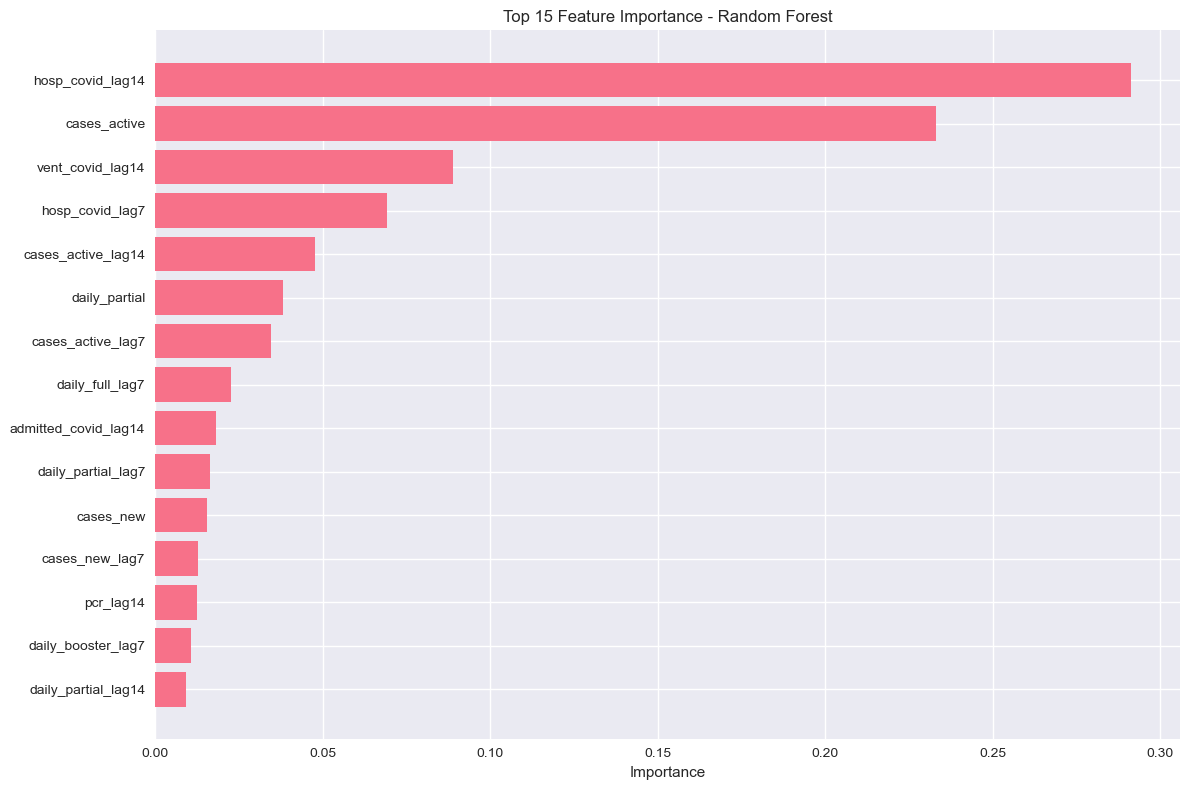

Top 10 Most Important Features:
             feature  importance
    hosp_covid_lag14    0.291356
        cases_active    0.233093
    vent_covid_lag14    0.088917
     hosp_covid_lag7    0.069095
  cases_active_lag14    0.047582
       daily_partial    0.038236
   cases_active_lag7    0.034559
     daily_full_lag7    0.022627
admitted_covid_lag14    0.018072
  daily_partial_lag7    0.016441


In [17]:
# Section 11: Feature Importance Analysis (for tree-based models)
def analyze_feature_importance(models, training_sets):
    """
    Analyze feature importance for tree-based models
    """
    # Combine all training data to get feature names
    all_train_data = pd.concat([training_sets[name] for name in training_sets.keys()], 
                              ignore_index=True)
    feature_names = all_train_data.drop('deaths_new', axis=1).columns
    
    # Get feature importance from Random Forest
    if hasattr(models['Random Forest'], 'feature_importances_'):
        rf_importance = models['Random Forest'].feature_importances_
        
        # Create dataframe for feature importance
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': rf_importance
        }).sort_values('importance', ascending=False)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        plt.barh(feature_importance_df['feature'][:15], 
                feature_importance_df['importance'][:15])
        plt.xlabel('Importance')
        plt.title('Top 15 Feature Importance - Random Forest')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print("Top 10 Most Important Features:")
        print(feature_importance_df.head(10).to_string(index=False))
    
    return feature_importance_df

# Analyze feature importance
feature_importance_df = analyze_feature_importance(models, training_sets_processed)